# Fragment length frequency (1 mark) + rescaling (2 marks)

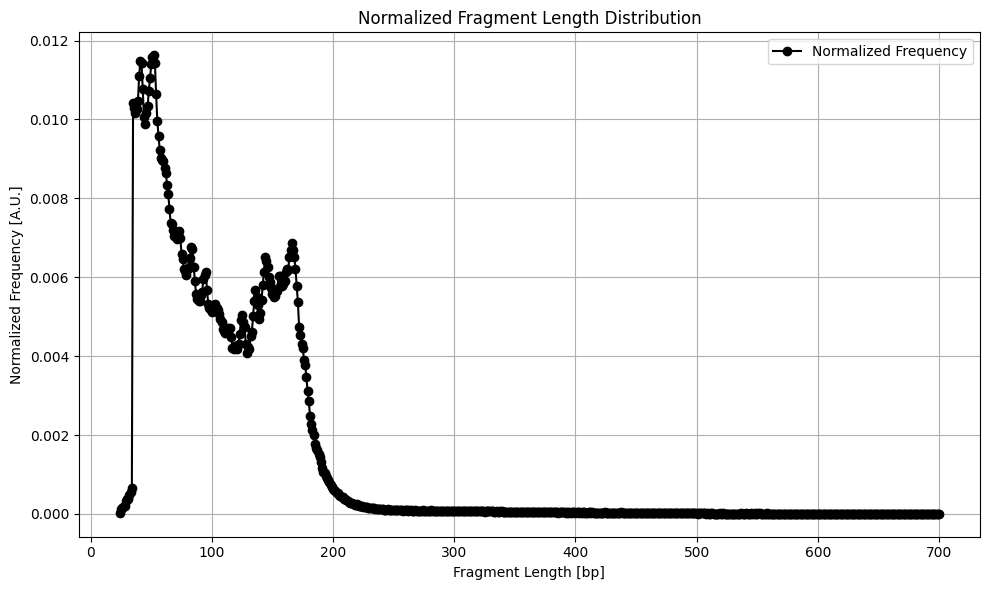

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

# Define the path to the input BED file
query_bed_path = "/kaggle/input/query-data/query.bed"

# Load fragment lengths from the BED file
def load_fragment_lengths(bed_path):
    fragment_lengths = []
    try:
        with open(bed_path, "r") as f:
            for line in f:
                if line.strip():
                    fields = line.strip().split('\t')
                    if len(fields) >= 3:
                        start = int(fields[1])
                        end = int(fields[2])
                        # Calculate fragment length
                        fragment_lengths.append(end - start)
        return fragment_lengths
    except FileNotFoundError:
        print(f"Error: File not found at {bed_path}")
        return []
    except Exception as e:
        print(f"Error reading BED file: {e}")
        return []

# Main processing
fragment_lengths = load_fragment_lengths(query_bed_path)
if not fragment_lengths:
    print("No fragment lengths were loaded. Exiting.")
    exit()

# Count the frequency of each fragment length
length_counts = Counter(fragment_lengths)

# Normalize the frequencies to values between 0 and 1
total_counts = sum(length_counts.values())
normalized_freqs = {length: count / total_counts for length, count in length_counts.items()}

# Sort the fragment lengths
sorted_lengths = sorted(normalized_freqs.items())
x_vals = [length for length, _ in sorted_lengths]
y_vals = [freq for _, freq in sorted_lengths]

# Plot the normalized fragment length distribution
plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, marker='o', color='black', label='Normalized Frequency')
plt.xlabel("Fragment Length [bp]")
plt.ylabel("Normalized Frequency [A.U.]")
plt.title("Normalized Fragment Length Distribution")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Sampling weights — min: 1.0243902577379007e-08 max: 8.190277265422965e-07 mean: 7.227659791451659e-08


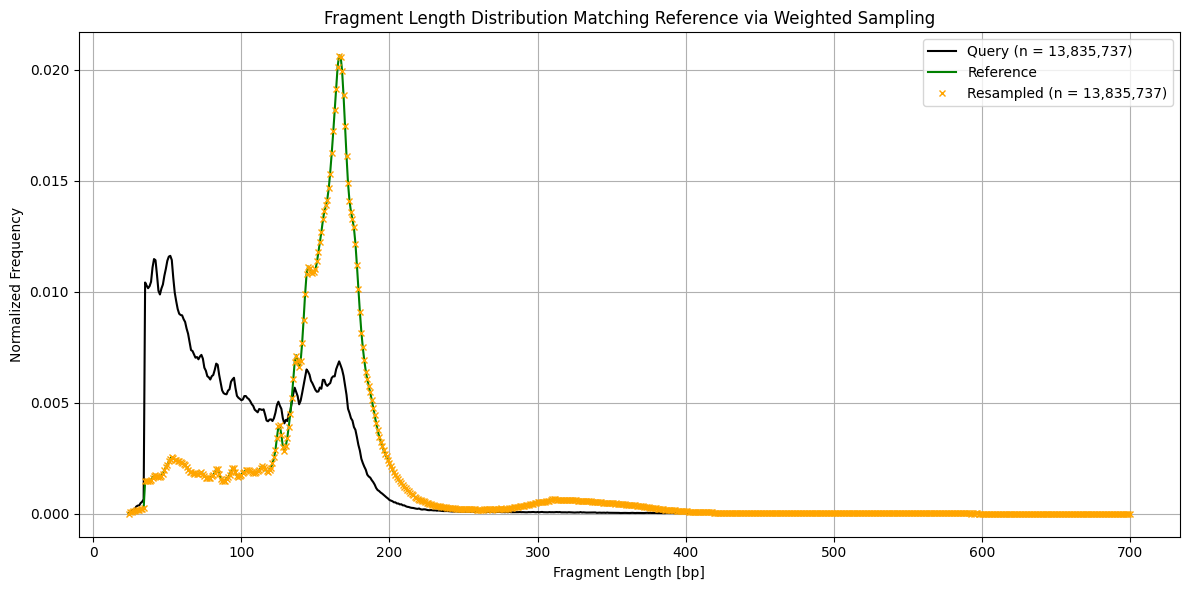

In [3]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Paths to input files
query_bed_path = "/kaggle/input/query-data/query.bed"
reference_hist_path = "/kaggle/input/reference-hist/reference.hist"

# Load fragment lengths from BED file
def load_fragment_lengths(bed_path):
    fragment_lengths = []
    try:
        with open(bed_path, "r") as f:
            for line in f:
                cols = line.strip().split('\t')
                if len(cols) >= 3:
                    start, end = int(cols[1]), int(cols[2])
                    fragment_lengths.append(end - start)
        return fragment_lengths
    except FileNotFoundError:
        print(f"Error: File not found at {bed_path}")
        return []
    except Exception as e:
        print(f"Error reading BED file: {e}")
        return []

# Load reference distribution
def load_reference_distribution(hist_path):
    reference_probs = {}
    try:
        with open(hist_path, "r") as f:
            for line in f:
                length, prob = line.strip().split('\t')
                reference_probs[int(length)] = float(prob)
        return reference_probs
    except FileNotFoundError:
        print(f"Error: File not found at {hist_path}")
        return {}
    except Exception as e:
        print(f"Error reading reference histogram: {e}")
        return {}

# Plotting function
def plot_distribution(data_dict, label, style, color):
    items = sorted(data_dict.items())
    x = [k for k, _ in items]
    y = [v for _, v in items]
    plt.plot(x, y, style, label=label, color=color)

def plot_distribution2(data_dict, label, style, color, marker=None):
    items = sorted(data_dict.items())
    x = [k for k, _ in items]
    y = [v for _, v in items]
    plt.plot(x, y,
             linestyle=style if style != 'None' else 'None',
             marker=marker,
             label=label,
             color=color,
             markersize=4)

# Main processing
fragment_lengths = load_fragment_lengths(query_bed_path)
if not fragment_lengths:
    print("No fragment lengths were loaded. Exiting.")
    exit()

reference_probs = load_reference_distribution(reference_hist_path)
if not reference_probs:
    print("No reference distribution was loaded. Exiting.")
    exit()

# Query histogram
query_counts = Counter(fragment_lengths)
total_query = sum(query_counts.values())
query_freqs = {l: c / total_query for l, c in query_counts.items()}

# Compute sampling weights (with small epsilon for stability)
sampling_weights = []
for l in fragment_lengths:
    ref_p = reference_probs.get(l, 1e-9)
    query_p = query_freqs.get(l, 1e-9)
    weight = ref_p / query_p
    sampling_weights.append(weight)

# Normalize weights
sampling_weights = np.array(sampling_weights)
sampling_weights = sampling_weights / sampling_weights.sum()

# Optional: Debug info
print("Sampling weights — min:", np.min(sampling_weights),
      "max:", np.max(sampling_weights),
      "mean:", np.mean(sampling_weights))

# Sample WITH replacement based on weights (use 100% of data for better match)
n_samples = total_query  # Use full size to reduce sampling noise
resampled_indices = np.random.choice(len(fragment_lengths), size=n_samples, replace=True, p=sampling_weights)
resampled_fragments = [fragment_lengths[i] for i in resampled_indices]

# Histogram and normalize resampled fragments
resampled_counts = Counter(resampled_fragments)
total_resampled = sum(resampled_counts.values())
resampled_freqs = {l: c / total_resampled for l, c in resampled_counts.items()}

# Plot all distributions
plt.figure(figsize=(12, 6))
plot_distribution(query_freqs, f"Query (n = {total_query:,})", '-', 'black')
plot_distribution(reference_probs, "Reference", 'None', 'green')
plot_distribution2(resampled_freqs, f"Resampled (n = {total_resampled:,})", 'None', 'orange', marker='x')

plt.xlabel("Fragment Length [bp]")
plt.ylabel("Normalized Frequency")
plt.title("Fragment Length Distribution Matching Reference via Weighted Sampling")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()